In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(
c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_pi_pulse_ZZ
imported experiments.two_

In [4]:
save_data = True

In [5]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [49]:
# expt_path=os.getcwd()+'\data_220623'
# expt_path=os.getcwd()+'\data_220712'
# expt_path=os.getcwd()+'\data_220801'
# expt_path=os.getcwd()+'\data_220904'
# expt_path=os.getcwd()+'\data_220919'
expt_path=os.getcwd()+'\data_220929'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data_220929


In [50]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


Load config

In [51]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Qubit/resonator to probe

In [52]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [116]:
qubit_i = 0
results_Qi = all_results[qubit_i]

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [54]:
im = InstrumentManager()

In [15]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [55]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

# RFSoC Calibration

In [18]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=1, # [us]
    readout_length=2, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=500, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)
tof.go(analyze=False, display=False, progress=True, save=False)

430 614
readout freq 950 +/- -806.77


  0%|          | 0/500 [00:00<?, ?it/s]

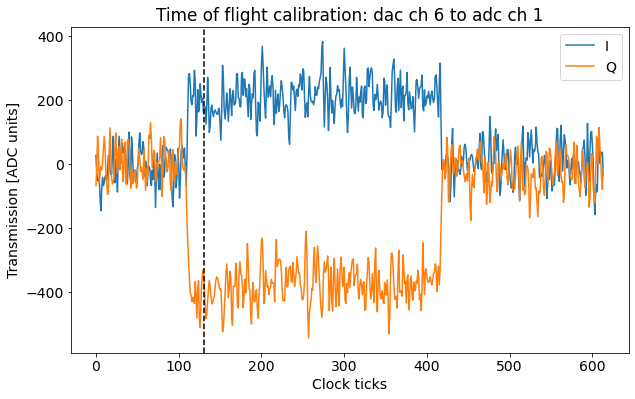

In [19]:
tof.display(adc_trig_offset=130)

# Initial single tone resonator spectroscopy

In [117]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 2.5 # MHz
npts = 100
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=800,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain = 0.850
rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
rspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/100 [00:00<?, ?it/s]

[812.8334999999998, 5000, 1000, 0, 25.953703586557644, 73.50174025209336]
[ 8.13076195e+02  1.66156645e+09  5.75467259e+03 -8.94260698e-01
  2.54452550e+01  4.90176247e+01]

Freq with minimum transmission: 813.021
Freq with maximum transmission: 813.221
From fit:
	f0: 813.0761946449605
	Qi: 1661566449.4503489
	Qe: 5754.672588923818
	Q0: 5754.652658248206
	kappa [MHz]: 0.1412902294771118
	phi [radians]: -0.8942606979811144


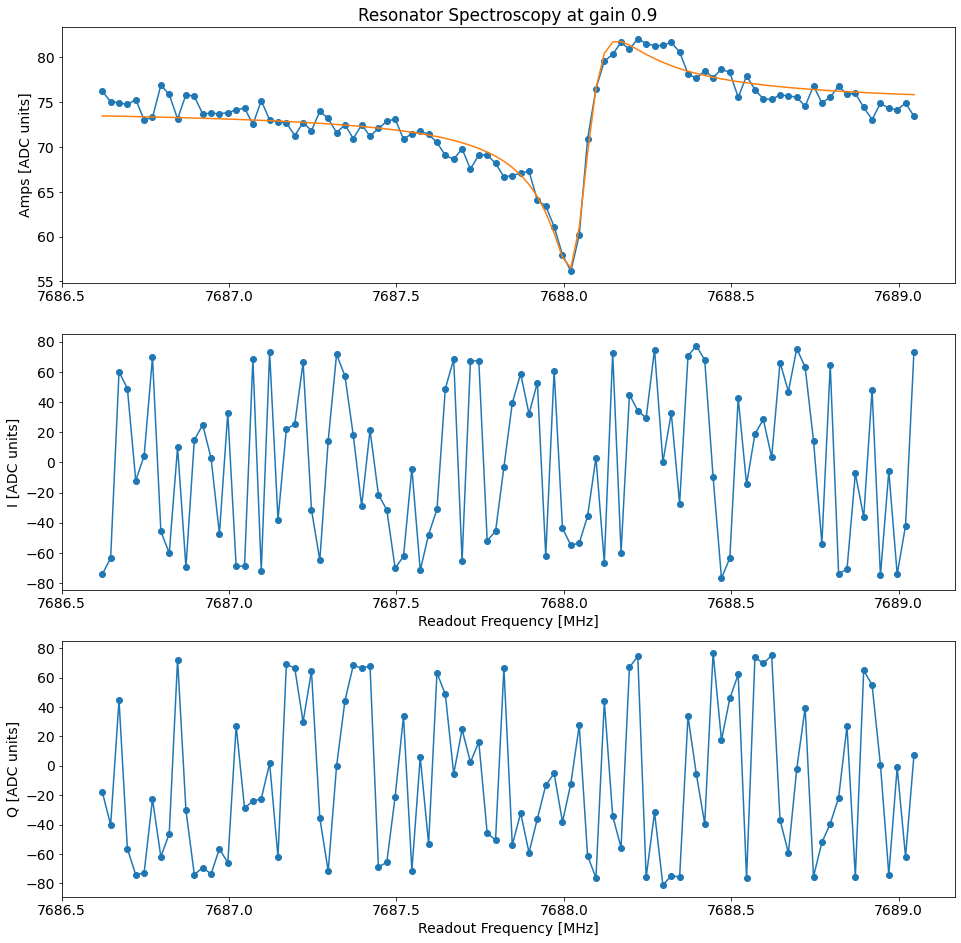

*Set cfg res 0 freq to 813.021*
*Set cfg res 0 gain to 0.9*
[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]


In [118]:
 # TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]
yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(all_results)

In [119]:
if save_data: saved_files.append(rspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00000_resonator_spectroscopy_qubit0.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [120]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 200
npts = 200

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 825.7898829999373, HWHM -2.2497192408756317
Found peak in I at [MHz] 825.8542388506143, HWHM -2.3670638463262472
Found peak in Q at [MHz] 825.6767456648627, HWHM -2.174796208703463


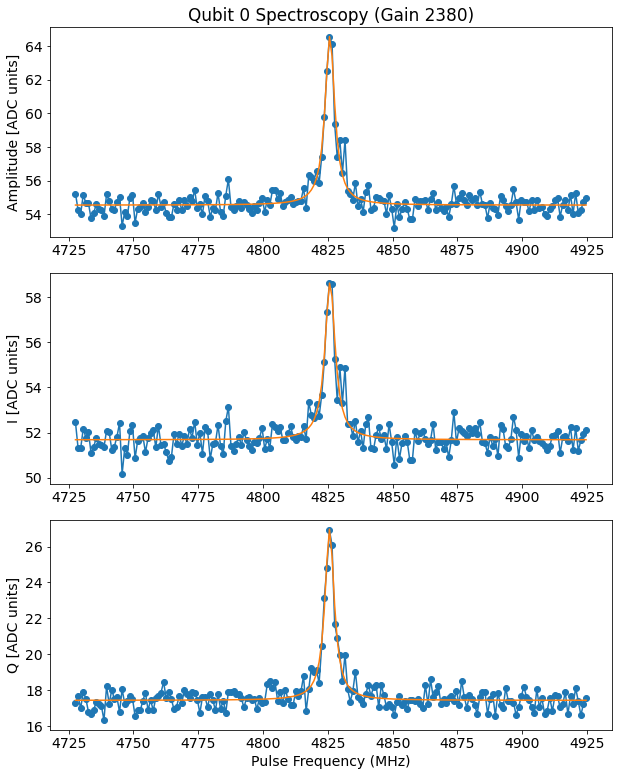

*Set qubit 0 f_ge to 825.6767456648627*
[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118, 'Qubit freq': 4825.676745664863}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]


In [121]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data, compare_param_i=1)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [122]:
if save_data: saved_files.append(qspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00000_qubit_spectroscopy_qubit0.h5


## Pulse Probe (qubit) spectroscopy round 2

In [123]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 150

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 825.0618653312251, HWHM 2.8705335921364035
Found peak in I at [MHz] 825.0522320047228, HWHM 2.7433535928884982
Found peak in Q at [MHz] 825.0839709660651, HWHM 3.286965453186869


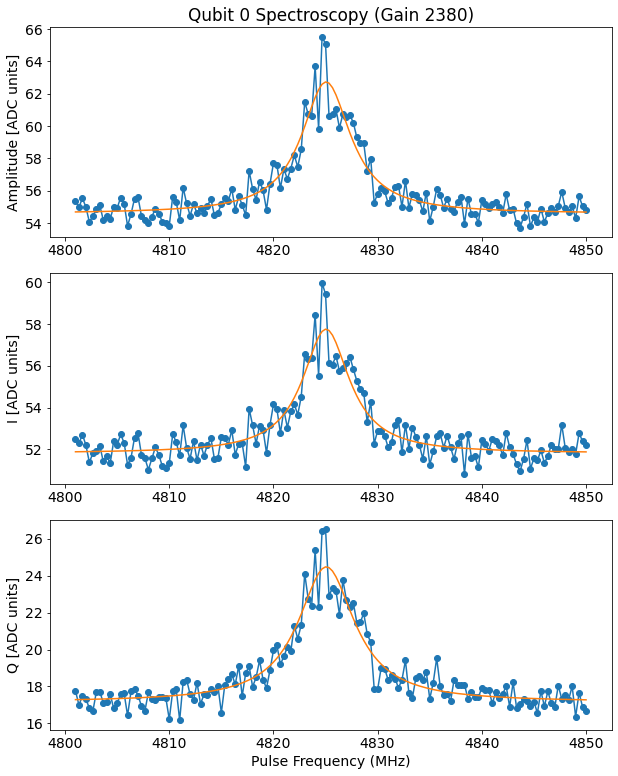

*Set qubit 0 f_ge to 825.0839709660651*
[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118, 'Qubit freq': 4825.083970966065}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]


In [124]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data, compare_param_i=1)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [125]:
if save_data: saved_files.append(qspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00001_qubit_spectroscopy_qubit0.h5


## Length Rabi

In [126]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=151,
    reps=4000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubit=qubit_i,
)
lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]
lengthrabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

Decay from avgi [us] 2.1808782587263686
Pi length from avgi data [us]: 0.04376842831479537
	Pi/2 length from avgi data [us]: 0.021884214157397684

Decay from avgq [us] 3.239960726584691
Pi length from avgq data [us]: 0.04322476286551088
Pi/2 length from avgq data [us]: 0.02161238143275544


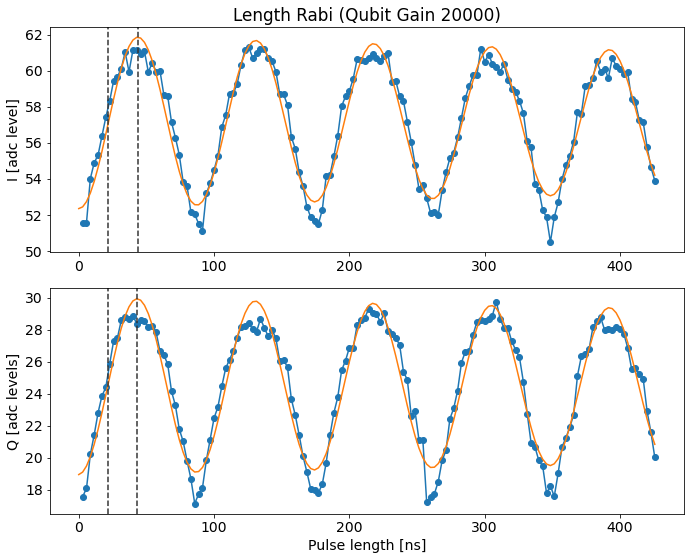

Will use sigma 0.03924859484312203 for amplitude rabi


In [127]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data, compare_param_i=1)

lengthrabi.display(fit=True)
p = lengthrabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
else: pi_len = (3/2 - p[2]/180)/2/p[1]
pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

lengthrabi_decay = p[3]

print(f'Will use sigma {pi_len} for amplitude rabi')

In [128]:
if save_data: saved_files.append(lengthrabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00000_length_rabi_qubit0.h5


## Amplitude Rabi

In [129]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=30,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.0011690363349131123, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
Attempted to init fitparam 1 to 0.0005371248025276462, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
Attempted to init fitparam 1 to 0.0007898894154818325, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
2
Pi gain from avgi data [dac units]: 22352
	Pi/2 gain from avgi data [dac units]: 11176
Pi gain from avgq data [dac units]: 22275
	Pi/2 gain from avgq data [dac units]: 11137


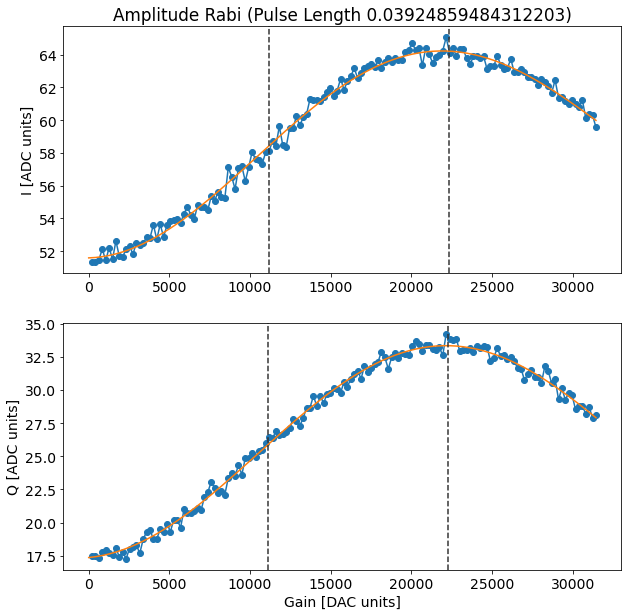

*Set pi pulse sigma for qubit 0 to 0.03924859484312203*
*Set pi pulse gain for qubit 0 to 22275*
[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118, 'Qubit freq': 4825.083970966065, 'Pi pulse len': 0.03924859484312203, 'Pi pulse gain': 22275}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]


In [130]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data, compare_param_i=2, override='avgq')

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(all_results)

In [131]:
if save_data: saved_files.append(amprabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00000_amp_rabi_qubit0.h5


## $T_1$

In [132]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = False

In [133]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 300
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    # reps=5,
    rounds=30,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Fit T1 avgi [us]: 74.5458646771357
Fit T1 avgq [us]: 74.19521258825213


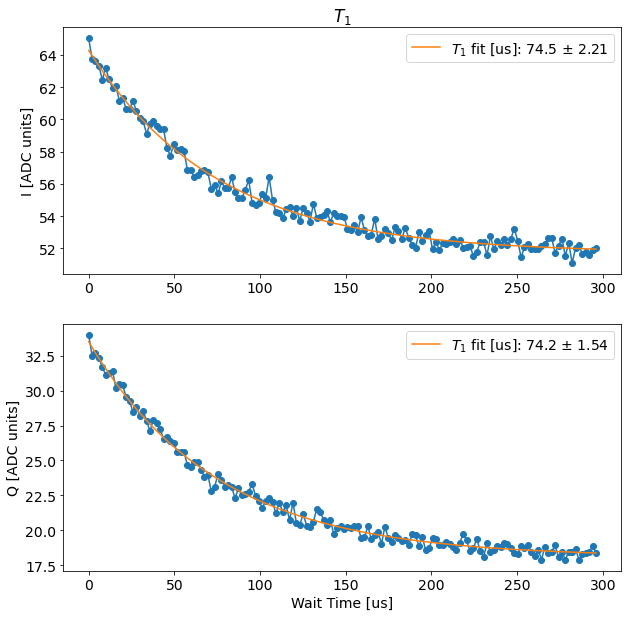

*Set qubit 0 T1 to 75.0*
*Set readout 0 relax delay to 224.0*
[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118, 'Qubit freq': 4825.083970966065, 'Pi pulse len': 0.03924859484312203, 'Pi pulse gain': 22275, 'T1': 74.5458646771357, 'T1 err': 2.2073002495489393}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]


In [134]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit=True)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data, compare_param_i=3)

t1.display(fit=True)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(3*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(all_results)

In [135]:
if save_data: saved_files.append(t1.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00000_t1_qubit0.h5


## $T_2$ Ramsey round 1

In [137]:
ramsey_freq = max(min(np.abs(np.ceil(qubit_hwhm)), 3), 2)
print(f'Ramsey freq [MHz]: {ramsey_freq}')

t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=151,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=100,
    # reps=5,
    rounds=30,
    qubit=qubit_i,
)
t2r.go(analyze=False, display=False, progress=True, save=False)

Ramsey freq [MHz]: 3


  0%|          | 0/30 [00:00<?, ?it/s]

Current qubit frequency: 825.0839709660651
Fit frequency from I [MHz]: 2.6220109502425597 +/- 0.0013383752395498773
Suggested new qubit frequency from fit I [MHz]:
 	825.4619600158225
 	819.4619600158225
T2 Ramsey from fit I [us]: 17.69521932308429
Fit frequency from Q [MHz]: 2.6217975983980386 +/- 0.0010069611251995246
Suggested new qubit frequencies from fit Q [MHz]:
 	825.462173367667
 	819.462173367667
T2 Ramsey from fit Q [us]: 17.708151807175415


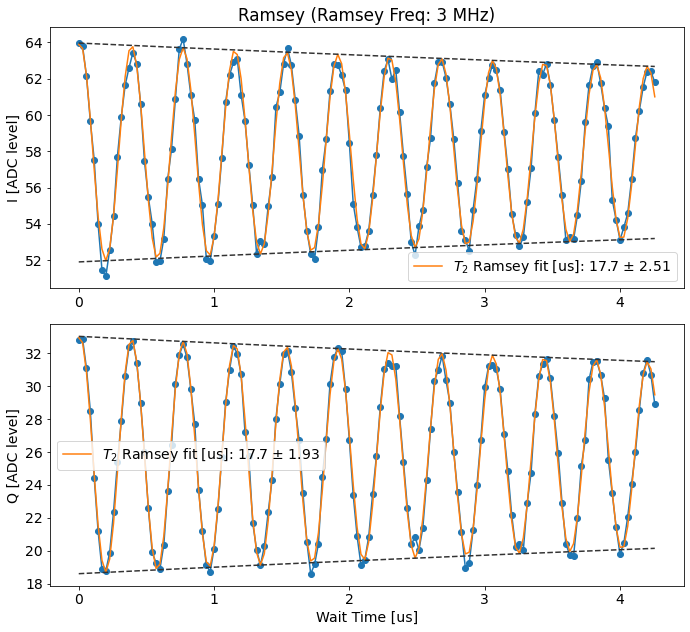

*Set qubit 0 freq to 825.4620257412722*
Alt qubit freq is 819.4620257412722


In [138]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

t2r.analyze(fit=True)

t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

In [139]:
if save_data: saved_files.append(t2r.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00000_ramsey_qubit0.h5


## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [140]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(60), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/10, # [MHz]
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Current qubit frequency: 825.4620257412722
Fit frequency from I [MHz]: 0.27831180270592887 +/- 0.0007285698902185869
Suggested new qubit frequency from fit I [MHz]:
 	825.4837139385663
 	824.8837139385663
T2 Ramsey from fit I [us]: 12.618432610610357
Fit frequency from Q [MHz]: 0.27855067655021404 +/- 0.0006535563766190601
Suggested new qubit frequencies from fit Q [MHz]:
 	825.483475064722
 	824.883475064722
T2 Ramsey from fit Q [us]: 13.641774823091382


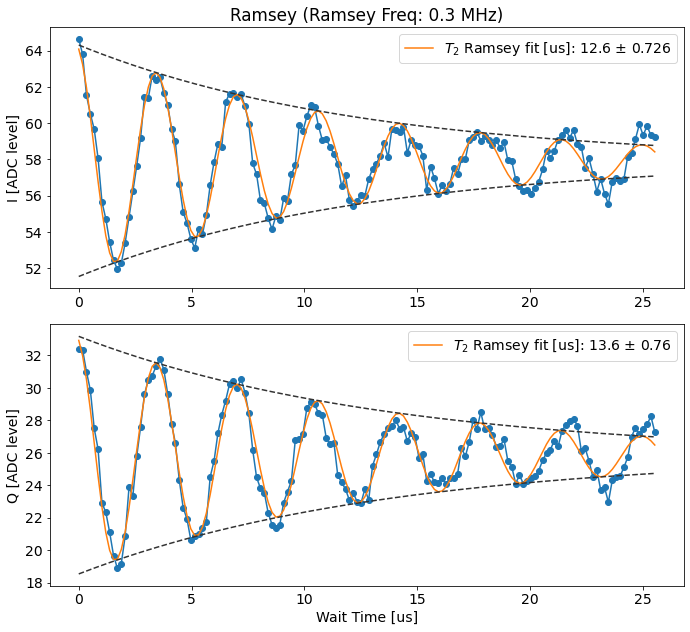

*Set qubit 0 freq to 825.4836182246191*
[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118, 'Qubit freq': 4825.483618224619, 'Pi pulse len': 0.03924859484312203, 'Pi pulse gain': 22275, 'T1': 74.5458646771357, 'T1 err': 2.2073002495489393, 'T2R': 12.959496410730917, 'T2R err': 0.6862245123751733}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]
Redo T2R: False


In [141]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(all_results)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [142]:
if save_data: saved_files.append(t2r_2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00001_ramsey_qubit0.h5


## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [331]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=100,
        # reps=10,
        rounds=30,
        qubit=qubit_i,
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

In [332]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    t2r_3_fit, t2r_3_fit_err, t2r_3_adjust = meas.fitting.get_best_fit(t2r_3.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

In [333]:
if redo_t2r:
    if save_data: saved_files.append(t2r_3.save_data())

## $T_2$ Echo

In [144]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(60), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=max(ramsey_freq/10, 0.100), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Current qubit frequency: 825.4836182246191
Fit frequency from I [MHz]: 0.30002887307974785 +/- 0.0002230742029346231
Suggested new qubit frequency from fit I [MHz]:
 	825.4835893515394
 	824.8835893515394
T2 Echo from fit I [us]: 45.89090681220864
Fit frequency from Q [MHz]: 0.29981312214841654 +/- 0.00019361641651804867
Suggested new qubit frequencies from fit Q [MHz]:
 	825.4838051024707
 	824.8838051024708
T2 Echo from fit Q [us]: 54.198204844530075


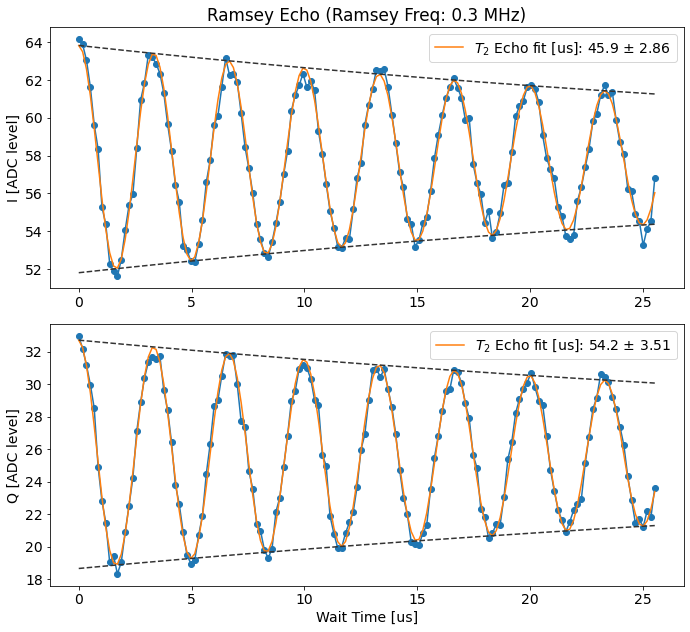

[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118, 'Qubit freq': 4825.483618224619, 'Pi pulse len': 0.03924859484312203, 'Pi pulse gain': 22275, 'T1': 74.5458646771357, 'T1 err': 2.2073002495489393, 'T2R': 12.959496410730917, 'T2R err': 0.6862245123751733, 'T2E': 48.69449475650649, 'T2E err': 2.3542449514288295}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]


In [145]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

t2e.analyze(fit=True)

t2e_fit, t2e_fit_err, t2e_adjust = meas.fitting.get_best_fit(t2e.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(all_results)
# print('Results updated.')

In [146]:
if save_data: saved_files.append(t2e.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00000_echo_qubit0.h5


# Resonator chi shift (g/e)

In [337]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[81.68719929911998, 5000, 1000, -1.5707963267948966, 26.515973718799614, 1035.5624377017807]
[ 8.01619645e+01 -1.92187460e+07  2.88565699e+01  1.41149519e+01
  2.02697440e+01  1.01697950e+03]

Freq with minimum transmission: 80.92560989514648
Freq with maximum transmission: 79.26998075607364
From fit:
	f0: 80.16196449578753
	Qi: -19218745.95817718
	Qe: 28.856569918057765
	Q0: 28.85661324569629
	kappa [MHz]: 2.7779408419573626
	phi [radians]: 14.114951899690919


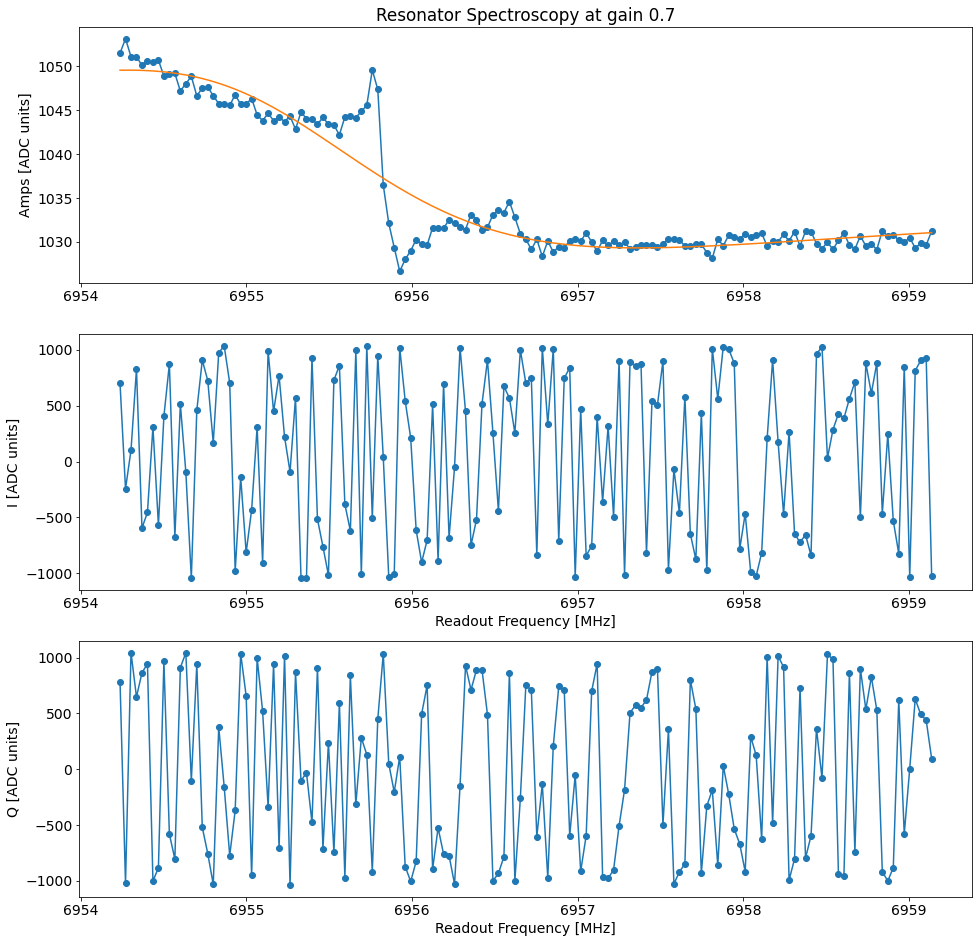

[{'Res freq': 7687.846, 'Res kappa': 0.10096224507081021, 'Qubit freq': 4826.624641934252, 'Pi pulse len': 0.04032902482621429, 'Pi pulse gain': 23801, 'T1': 72.8043441531919, 'T1 err': 5.725028652108308, 'T2R': 24.740454530964936, 'T2R err': 6.239873306288155, 'T2E': 33.2434000431927, 'T2E err': 7.88273049076608, 'Res chi shift (e - g)': -0.9259337748344478, 'Qubit EF freq': 4637.276473347379, 'EF pi pulse len': 0.02, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.0033112582781314}, {'Res freq': 5782.358, 'Res kappa': 0.21016486158321973, 'Qubit freq': 3470.204764189285, 'Pi pulse len': 0.019740766230314902, 'Pi pulse gain': 21866, 'T1': 127.71791655525085, 'T1 err': 4.4314616189917535, 'T2R': 7.03014808133608, 'T2R err': 0.4773570086874325, 'T2E': 31.87234676383387, 'T2E err': 4.217801982185171, 'Res chi shift (e - g)': -0.8200538276795442, 'Qubit EF freq': 3369.7243020025294, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 16999, 'Res chi shift (f - g)': 0.01655629139077064}, 

In [338]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = -83
results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [339]:
if save_data: saved_files.append(rspec_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_resonator_spectroscopy_chi_qubit3.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [147]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 100
npts = 180

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=2, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    # gain=5000,
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 636.4556419415281, HWHM 2.6167144597670213
Found peak in I at [MHz] 636.4619851089244, HWHM 2.620150320012226
Found peak in Q at [MHz] 636.4060174208847, HWHM 2.821280082116805


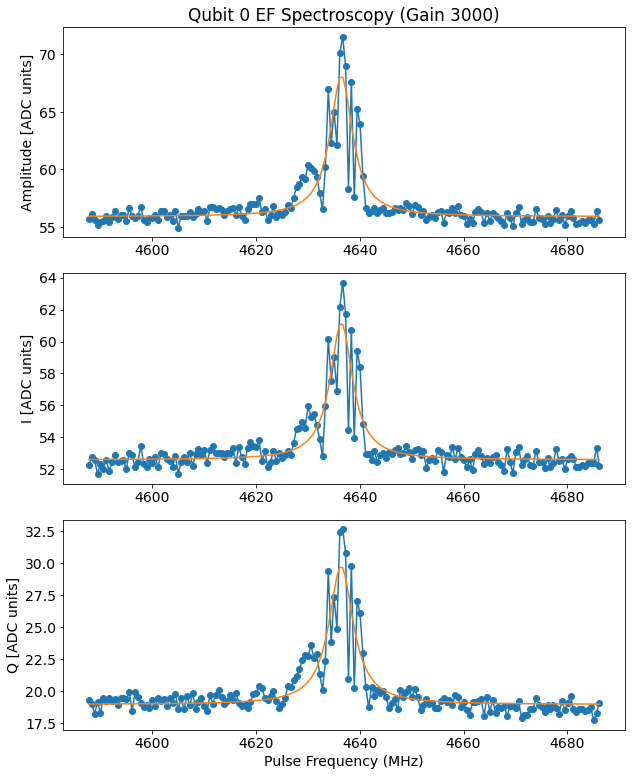

*Set qubit 0 f_ef to 636.4619851089244*
[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118, 'Qubit freq': 4825.483618224619, 'Pi pulse len': 0.03924859484312203, 'Pi pulse gain': 22275, 'T1': 74.5458646771357, 'T1 err': 2.2073002495489393, 'T2R': 12.959496410730917, 'T2R err': 0.6862245123751733, 'T2E': 48.69449475650649, 'T2E err': 2.3542449514288295, 'Qubit EF freq': 4636.461985108925}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]


In [148]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [149]:
if save_data: saved_files.append(qEFspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00000_qubit_EF_spectroscopy_qubit0.h5


## Pulse Probe EF spectroscopy round 2

In [150]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=4, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 636.5238559118534, HWHM 4.665521830527194
Found peak in I at [MHz] 636.554051108805, HWHM 4.662574308319181
Found peak in Q at [MHz] 636.4782461701366, HWHM 4.796619851632108


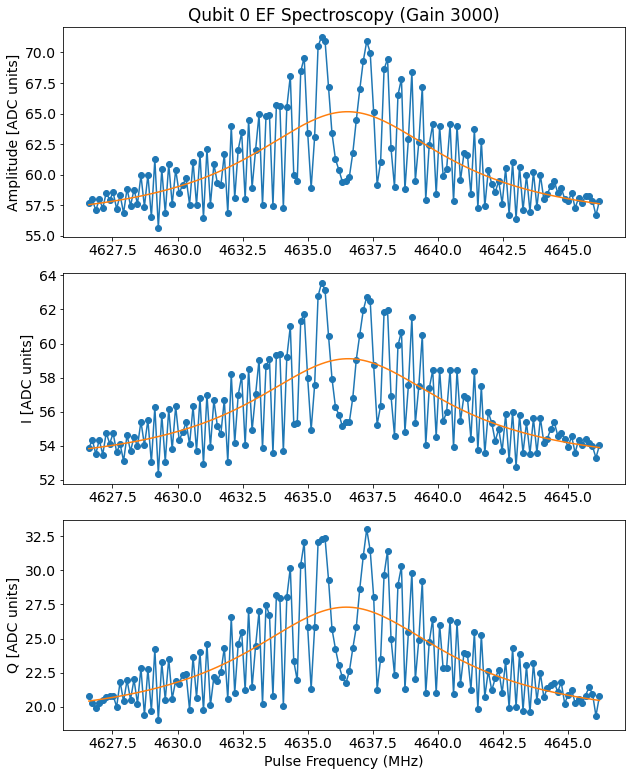

*Set qubit 0 f_ef to 636.554051108805*
[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118, 'Qubit freq': 4825.483618224619, 'Pi pulse len': 0.03924859484312203, 'Pi pulse gain': 22275, 'T1': 74.5458646771357, 'T1 err': 2.2073002495489393, 'T2R': 12.959496410730917, 'T2R err': 0.6862245123751733, 'T2E': 48.69449475650649, 'T2E err': 2.3542449514288295, 'Qubit EF freq': 4636.554051108805}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]


In [151]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data, compare_param_i=2)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [152]:
if save_data: qEFspec2.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00001_qubit_EF_spectroscopy_qubit0.h5


## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [157]:
amprabiEF = meas.AmplitudeRabiEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=30,
    sigma_test=0.025, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [75.0, 128, 46, 58], 'f_ge': [825.4836182246191, 3470.7175501189595, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [636.554051108805, 3370.8072163480497, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.9, -1, 2681.7, 2384.37], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22275, 22191, 22539, 28755], 'sigma': [0.03924859484312203, 0.01968090066900493, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [30000, 21915, 20765, 29402], 'sigma': [0.015, 0.015, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 2850], 'sigma': [0.396, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [813.021, -807.6329999999999, -79.784, 81.64542225717739], 'lo_sideband': [1, -1,

  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from avgi data [dac units]: 19057
	Pi/2 gain from avgi data [dac units]: 9528
Pi gain from avgq data [dac units]: 19109
	Pi/2 gain from avgq data [dac units]: 9554


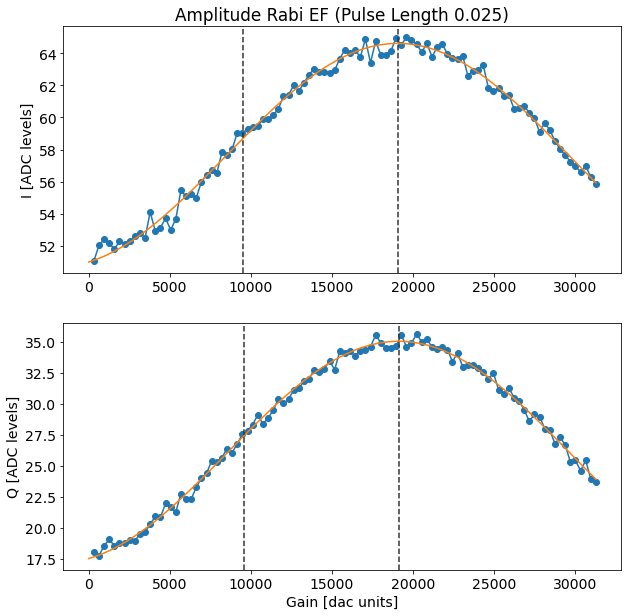

*Set EF pi pulse sigma for qubit 0 to 0.025*
*Set EF pi pulse gain for qubit 0 to 19109*
[{'Res freq': 7688.021, 'Res kappa': 0.1412902294771118, 'Qubit freq': 4825.483618224619, 'Pi pulse len': 0.03924859484312203, 'Pi pulse gain': 22275, 'T1': 74.5458646771357, 'T1 err': 2.2073002495489393, 'T2R': 12.959496410730917, 'T2R err': 0.6862245123751733, 'T2E': 48.69449475650649, 'T2E err': 2.3542449514288295, 'Qubit EF freq': 4636.554051108805, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 19109}, {'Res freq': 5782.633, 'Res kappa': 0.22230698649398947, 'Qubit freq': 3470.7175501189595, 'Pi pulse len': 0.01968090066900493, 'Pi pulse gain': 22191, 'Qubit EF freq': 3370.8072163480497, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21915}, {}, {}]


In [158]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data, compare_param_i=1)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [159]:
if save_data: amprabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00001_amp_rabi_EF_qubit0.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [156]:
ramseyEF_freq = max(min(np.abs(np.ceil(qubitEF_hwhm)), 4), 2)

t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    reps=100,
    rounds=30,
    qubit=qubit_i,
)
t2EFr.go(analyze=False, display=False, progress=True, save=False)

NameError: name 'ramsey_EFfreq' is not defined

Attempted to init fitparam 1 to 4.199958, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Attempted to init fitparam 1 to 3.966627, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Attempted to init fitparam 1 to 3.966627, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Current EF frequency: 275.2877943849682
Fit frequency from I [MHz]: 3.523454697986577
Suggested new EF frequencies from fit avgi [MHz]:
 	275.76433968698166
 	267.76433968698166
T2 Ramsey EF from fit avgi [us]: 0.31962563062633725
Fit frequency from Q [MHz]: 3.523454697986577
Suggested new EF frequencies from fit avgq [MHz]:
 	275.76433968698166
 	267.76433968698166
T2 Ramsey EF from fit avgq [us]: 0.3129558980842769


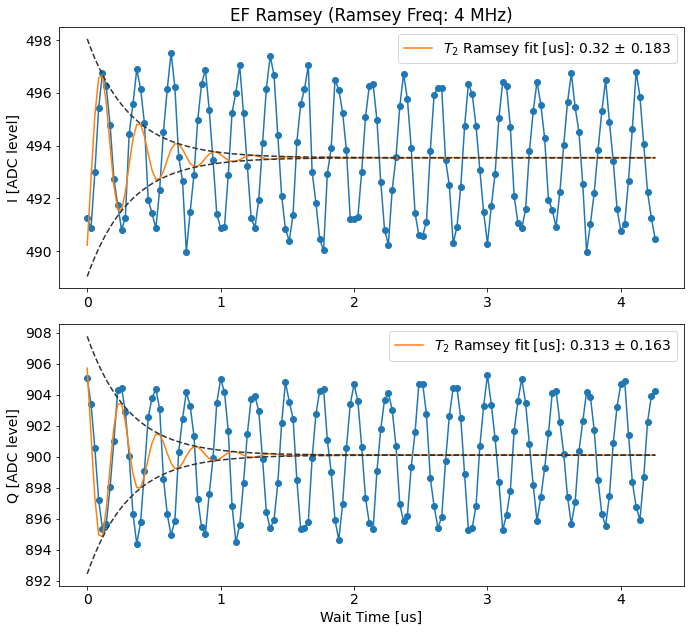

*Set qubit 3 EF freq to 275.76433968698353*
[{'Res freq': 7687.846, 'Res kappa': 0.10096224507081021, 'Qubit freq': 4826.624641934252, 'Pi pulse len': 0.04032902482621429, 'Pi pulse gain': 23801, 'T1': 72.8043441531919, 'T1 err': 5.725028652108308, 'T2R': 24.740454530964936, 'T2R err': 6.239873306288155, 'T2E': 33.2434000431927, 'T2E err': 7.88273049076608, 'Res chi shift (e - g)': -0.9259337748344478, 'Qubit EF freq': 4637.276473347379, 'EF pi pulse len': 0.02, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.0033112582781314}, {'Res freq': 5782.358, 'Res kappa': 0.21016486158321973, 'Qubit freq': 3470.204764189285, 'Pi pulse len': 0.019740766230314902, 'Pi pulse gain': 21866, 'T1': 127.71791655525085, 'T1 err': 4.4314616189917535, 'T2R': 7.03014808133608, 'T2R err': 0.4773570086874325, 'T2E': 31.87234676383387, 'T2E err': 4.217801982185171, 'Res chi shift (e - g)': -0.8200538276795442, 'Qubit EF freq': 3369.7243020025294, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 16999, 'Re

In [ ]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, compare_param_i=3, get_best_data_params=['f_ef_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [ ]:
if save_data: t2EFr.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_ramseyEF_qubit3.h5


# Resonator chi shift (e/f)

In [352]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[78.40905360375575, 5000, 1000, -1.5707963267948966, 68.1421698134302, 1065.003808735285]
[ 7.83294003e+01 -5.92205154e+03  6.77192575e+03 -2.37316928e+00
 -2.48627227e-05  1.06507017e+03]

Freq with minimum transmission: 80.85938472958357
Freq with maximum transmission: 75.95872247792794
From fit:
	f0: 78.32940025576205
	Qi: -5922.051542265934
	Qe: 6771.925750011051
	Q0: -47187.79904895139
	kappa [MHz]: -0.001659950280251579
	phi [radians]: -2.3731692844643164


c:\Users\slab\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


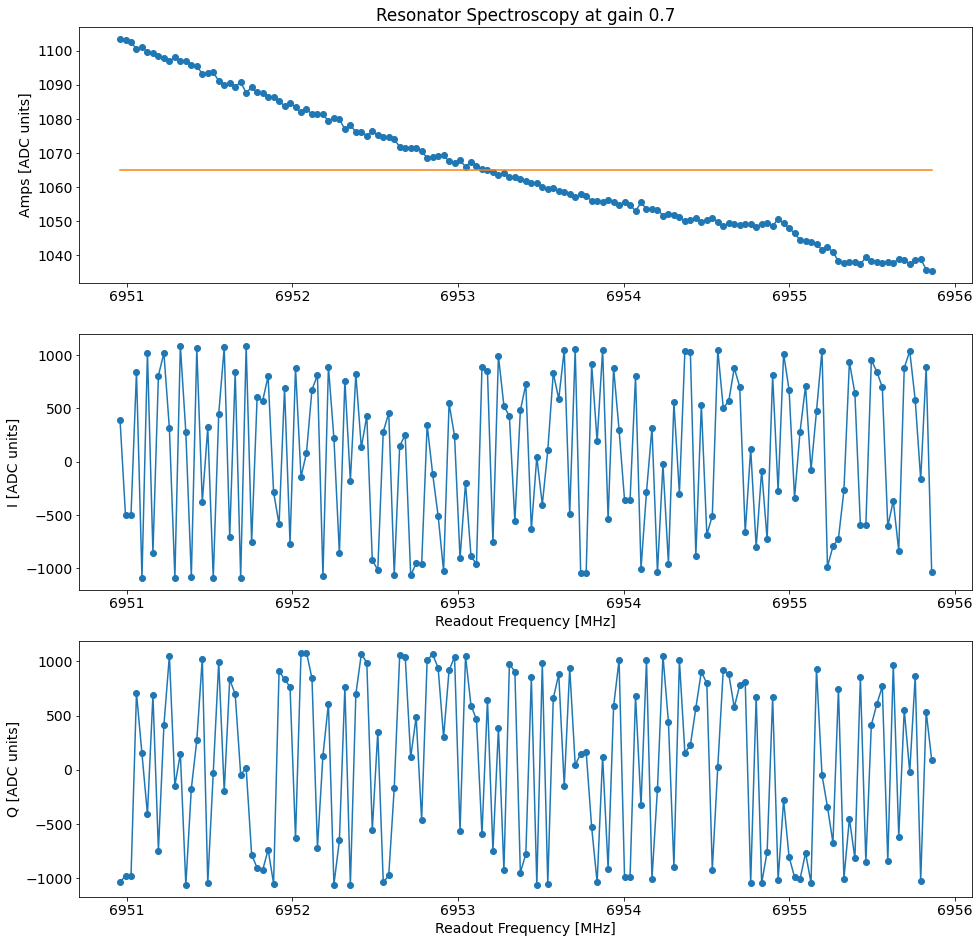

[{'Res freq': 7687.846, 'Res kappa': 0.10096224507081021, 'Qubit freq': 4826.624641934252, 'Pi pulse len': 0.04032902482621429, 'Pi pulse gain': 23801, 'T1': 72.8043441531919, 'T1 err': 5.725028652108308, 'T2R': 24.740454530964936, 'T2R err': 6.239873306288155, 'T2E': 33.2434000431927, 'T2E err': 7.88273049076608, 'Res chi shift (e - g)': -0.9259337748344478, 'Qubit EF freq': 4637.276473347379, 'EF pi pulse len': 0.02, 'EF pi pulse gain': 30000, 'Res chi shift (f - g)': -2.0033112582781314}, {'Res freq': 5782.358, 'Res kappa': 0.21016486158321973, 'Qubit freq': 3470.204764189285, 'Pi pulse len': 0.019740766230314902, 'Pi pulse gain': 21866, 'T1': 127.71791655525085, 'T1 err': 4.4314616189917535, 'T2R': 7.03014808133608, 'T2R err': 0.4773570086874325, 'T2E': 31.87234676383387, 'T2E err': 4.217801982185171, 'Res chi shift (e - g)': -0.8200538276795442, 'Qubit EF freq': 3369.7243020025294, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 16999, 'Res chi shift (f - g)': 0.01655629139077064}, 

In [353]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [354]:
if save_data: rspecEF_chi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00001_resonator_spectroscopy_chi_qubit3.h5


# Single Shot

## Single shot optimization

In [161]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz
span_f = 2*abs(results_Qi['Res kappa']) # MHz
npts_f = 10

span_gain = 0.9
# npts_gain = 2
npts_gain = 5

span_len = 10 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.200,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=10,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [75.0, 128, 46, 58], 'f_ge': [825.4836182246191, 3470.7175501189595, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [636.554051108805, 3370.8072163480497, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.9, -1, 2681.7, 2384.37], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22275, 22191, 22539, 28755], 'sigma': [0.03924859484312203, 0.01968090066900493, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [19109, 21915, 20765, 29402], 'sigma': [0.025, 0.015, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 2850], 'sigma': [0.396, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [813.021, -807.6329999999999, -79.784, 81.64542225717739], 'lo_sideband': [1, -1,

  0%|          | 0/10 [00:00<?, ?it/s]

freq: 812.8797097705228, gain: 0.2, len: 10.0
	fid ge [%]: 4.16510412760319
freq: 812.8797097705228, gain: 0.38, len: 10.0
	fid ge [%]: 6.595329766488324
freq: 812.8797097705228, gain: 0.56, len: 10.0
	fid ge [%]: 9.885494274713736
freq: 812.8797097705228, gain: 0.74, len: 10.0
	fid ge [%]: 12.975648782439123
freq: 812.8797097705228, gain: 0.9199999999999999, len: 10.0
	fid ge [%]: 15.73539338483462
freq: 812.9079678164182, gain: 0.2, len: 10.0
	fid ge [%]: 3.1100777519437983
freq: 812.9079678164182, gain: 0.38, len: 10.0
	fid ge [%]: 7.3151828795719895
freq: 812.9079678164182, gain: 0.56, len: 10.0
	fid ge [%]: 9.91549577478874
freq: 812.9079678164182, gain: 0.74, len: 10.0
	fid ge [%]: 13.190329758243957
freq: 812.9079678164182, gain: 0.9199999999999999, len: 10.0
	fid ge [%]: 14.631097332299921
freq: 812.9362258623137, gain: 0.2, len: 10.0
	fid ge [%]: 3.5550888772219307
freq: 812.9362258623137, gain: 0.38, len: 10.0
	fid ge [%]: 6.965348267413371
freq: 812.9362258623137, gain: 0.56

(6, 4, 0)
[812.87970977 812.90796782 812.93622586 812.96448391 812.99274195
 813.021      813.04925805 813.07751609 813.10577414 813.13403218]
[0.2  0.38 0.56 0.74 0.92]
[10.]
Max fidelity 0.32991649582479127
Set params: 
 angle (deg) -90.02142252060118 
 threshold 31.54249063721845 
 freq [Mhz] 813.0492580458954 
 gain [dac units] 0.9199999999999999 
 readout length [us] 10.0


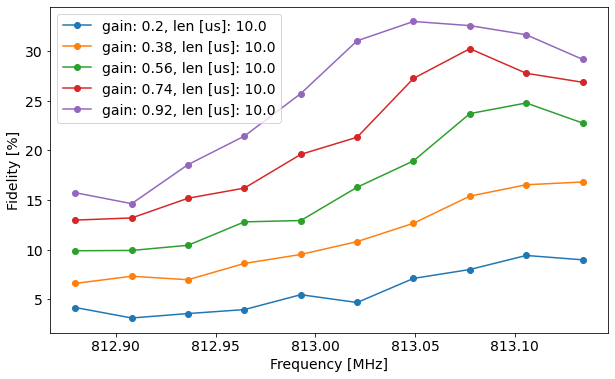

[[[0.04165104]
  [0.0659533 ]
  [0.09885494]
  [0.12975649]
  [0.15735393]]

 [[0.03110078]
  [0.07315183]
  [0.09915496]
  [0.1319033 ]
  [0.14631097]]

 [[0.03555089]
  [0.06965348]
  [0.10435261]
  [0.15175759]
  [0.18565464]]

 [[0.03955099]
  [0.08605215]
  [0.1279596 ]
  [0.1620081 ]
  [0.21442144]]

 [[0.05455273]
  [0.09510238]
  [0.12930323]
  [0.1959647 ]
  [0.25721929]]

 [[0.04670117]
  [0.1080554 ]
  [0.16285814]
  [0.21327133]
  [0.31045776]]

 [[0.07095177]
  [0.12655316]
  [0.18940947]
  [0.27253858]
  [0.3299165 ]]

 [[0.079952  ]
  [0.15390385]
  [0.23705593]
  [0.30248781]
  [0.32573257]]

 [[0.09410235]
  [0.16535413]
  [0.24776858]
  [0.27770694]
  [0.31652913]]

 [[0.08970449]
  [0.1681542 ]
  [0.22755569]
  [0.26865672]
  [0.29173647]]]


In [162]:
shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

In [163]:
if save_data: shotopt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220929\00000_single_shot_opt_qubit0.h5


## Best readout parameters

In [112]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=30000,
    check_f=False,
    qubit=qubit_i,
)

shot.cfg.device.readout.frequency=-807.4996158081035
shot.cfg.device.readout.gain=0.750
# shot.cfg.device.readout.readout_length = 7 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [73, 128, 46, 58], 'f_ge': [826.6246419342525, 3470.7175501189595, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [637.2764733473786, 3370.8072163480497, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.9, -1, 2681.7, 2384.37], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [23801, 22191, 22539, 28755], 'sigma': [0.0403, 0.01968090066900493, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [30000, 21915, 20765, 29402], 'sigma': [0.02, 0.015, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 2850], 'sigma': [0.396, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': -807.4996158081035, 'lo_sideband': [1, -1, 1, 1], 'gain': 0.75, 'readout_length': [10, 10, 10, 1

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Unrotated:
Ig -228.00862349495605 +/- 34.73066696321477 	 Qg 226.73283436381385 +/- 33.8484020188545 	 Amp g 321.55203399560895
Ie -222.84851936218678 +/- 32.042928480674526 	 Qe 274.24829157175395 +/- 37.4235880456991 	 Amp e 353.37457182421133
Rotated:
Ig 200.79689932235328 +/- 34.73066696321477 	 Qg 251.31932817295123 +/- 33.8484020188545 	 Amp g 321.6843165135267
Ie 248.65491085028535 +/- 32.042928480674526 	 Qe 250.99500719350223 +/- 37.4235880456991 	 Amp e 353.30972011257995


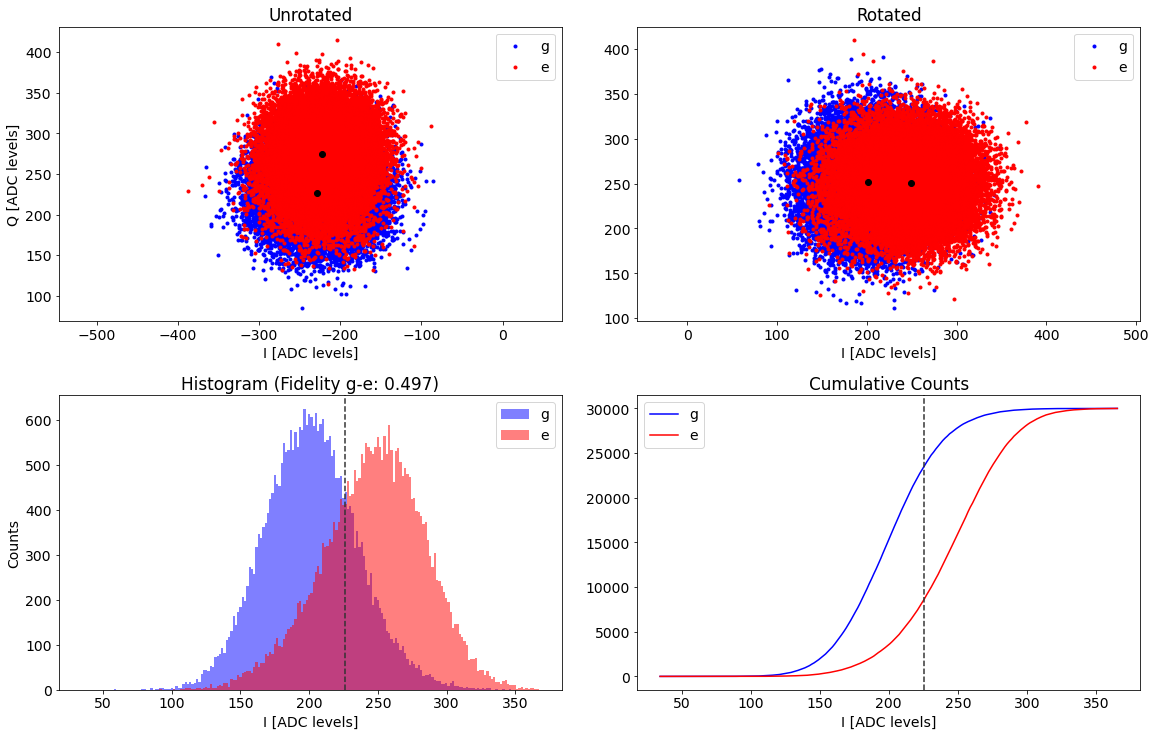

ge fidelity (%): 49.72414367863989
rotation angle (deg): -83.80205743696919
threshold ge: 225.74802982124493


In [113]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

In [367]:
if save_data: shot.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00001_single_shot_qubit3.h5


# Results

In [164]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

{'device': {'qubit': {'T1': [75.0, 128, 46, 58], 'f_ge': [825.4836182246191, 3470.7175501189595, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [636.554051108805, 3370.8072163480497, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.9, -1, 2681.7, 2384.37], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22275, 22191, 22539, 28755], 'sigma': [0.03924859484312203, 0.01968090066900493, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [19109, 21915, 20765, 29402], 'sigma': [0.025, 0.015, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 2850], 'sigma': [0.396, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [813.021, -807.6329999999999, -79.784, 81.64542225717739], 'lo_sideband': [1, -1,